# Dask dataframe example

This is an introduction to using Dask to run out-of-core computations on datasets.

In [1]:
import os

# Get number of CPUs allocated to your server
NUM_CPUS = int(os.environ['NUM_CPUS'])
print(f'Number of CPUs in server: {NUM_CPUS}')

Number of CPUs in server: 8


In [2]:
import dask
from dask import dataframe as dd
from dask.diagnostics import CacheProfiler, ResourceProfiler, Profiler, ProgressBar, visualize

In [3]:
# Set up default number of workers and enable global progress bar
dask.set_options(num_workers = NUM_CPUS)
progress_bar = ProgressBar()
progress_bar.register()

In [17]:
# Set up Bokeh for visualisation
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline
import matplotlib.pyplot as plt

Loading BokehJS ...

## Flight data from USA domestic flights 2001 - 2008

We will explore a dataset that contains information on every domestic flight in the USA between 2001 and 2008. Every year is a CSV file of ~600MB, so the compilation of all the years is at the level of annoying data: data that will typically not fit on a single node but is not large enough to warrant the overhead of <font size="4">Big Data™</font> technologies.

In [5]:
!du -hsc /project/data/200*.csv

573M	/project/data/2001.csv
506M	/project/data/2002.csv
598M	/project/data/2003.csv
639M	/project/data/2004.csv
640M	/project/data/2005.csv
641M	/project/data/2006.csv
671M	/project/data/2007.csv
658M	/project/data/2008.csv
4.9G	total


We read all CSVs with a wildcard into a Dask dataframe and select a few columns. Note that this is a delayed operation, the whole file has not been actually read when calling `read_csv`, but only the column names and types have been inferred from the first few lines of the file.

In [21]:
cols = ['Year','Month','DayOfWeek','DepDelay',
       'CRSDepTime','UniqueCarrier','Origin','Dest']
df = dd.read_csv('/project/data/200*.csv',usecols = cols)

In [20]:
df.info()


AttributeError: 'Series' object has no attribute 'info'

The `df` object contains the graph that dask will execute when the operation is computed. You can visualize it by calling the `visualize()` method.

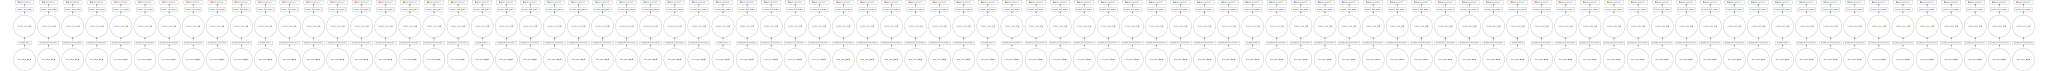

In [8]:
df.visualize(format='svg',size = '100,50')

In [9]:
df.visualize?

Now we can start to define operations that will be run on the dataframe. As above, these commands do not execute the analysis, only define an execution graph.

We build two new columns: 
- `hour`: the hour at which the flight departed
- `delayed`: whether the flight had more than 15 minutes delay.
    
On this new dataframe, we perform three aggregations: delay fraction by month, delay fraction by hour, and delay fraction by carrier.

In [10]:
df2 = (df.drop(['DepDelay','CRSDepTime'],axis = 1)
       .assign(hour = df.CRSDepTime.clip(upper = 2399)//100,
              delayed = (df.DepDelay.fillna(16)>15).astype('i8')))

In [23]:
df2.info()
df2.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, Year to hour
[########################################] | 100% Completed |  1.5s


,Year,Month,DayOfWeek,UniqueCarrier,Origin,Dest,delayed,hour
0,2001,1,3,US,BWI,CLT,0,18
1,2001,1,4,US,BWI,CLT,0,18
2,2001,1,5,US,BWI,CLT,0,18
3,2001,1,6,US,BWI,CLT,0,18
4,2001,1,7,US,BWI,CLT,0,18


In [12]:
# Define some aggregations to plot
aggregations = [df2.groupby('Year').delayed.mean(),
               df2.groupby('Month').delayed.mean(),
               df2.groupby('hour').delayed.mean(),
               df2.groupby('UniqueCarrier').delayed.mean().nlargest(20),]

Now we can visualize the execution graph of all the above operations that will be needed to carry out the computation of delayed fraction by carrier.

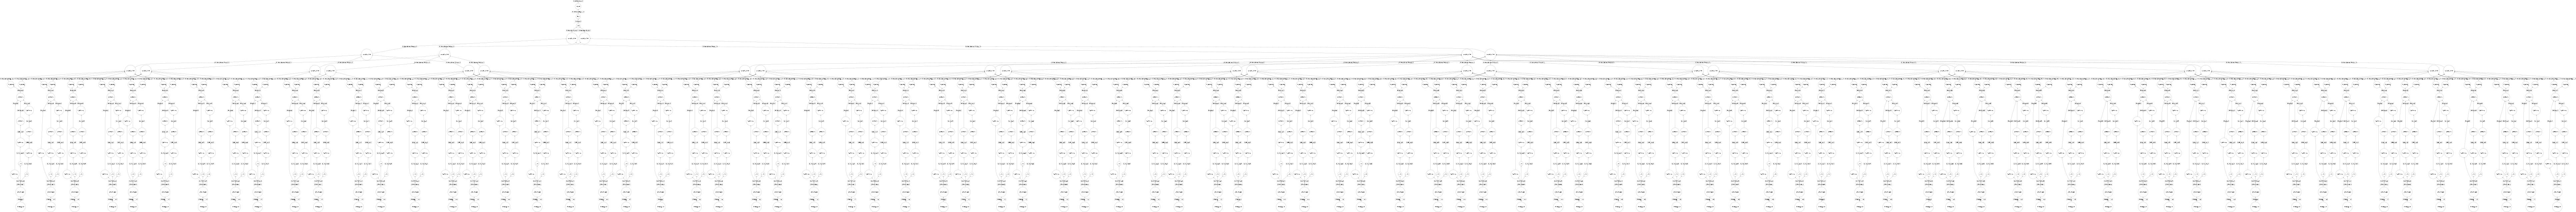

In [13]:
delayed_by_carrier_dask = aggregations[3]
delayed_by_carrier_dask.visualize(format = 'png',size ='80.50')

Finally, we can perform the actual computation! On any dask object you can call `.compute()` to obtain the computed value and execute the graph. Because here we have three aggregations that will use the same data, we group them in a single call to `dask.compute`, which helps optimize the reuse of intermediate data. 

In [14]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof, ProgressBar():
    # Compute them all in a single pass over the data
    (delayed_by_hour,
     delayed_by_month,
     delayed_by_year,
     delayed_by_carrier) = dask.compute(*aggregations, num_workers=NUM_CPUS)

[########################################] | 100% Completed |  1min  4.5s
[########################################] | 100% Completed |  1min  4.6s


Having wrapped the execution in the `with Profiler() ... ResourceProfiler()` context manager now allows us to visualize the resource usage of the execution. 

In [15]:
visualize([prof, rprof, cprof])

Column(id='a42a2b94-97b1-4181-8867-c5c79d2e0277', ...)

Finally, we can take a look at the aggregated metrics, which are regular pandas dataframes:

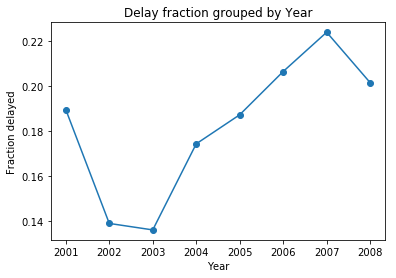

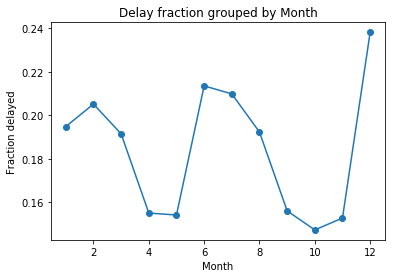

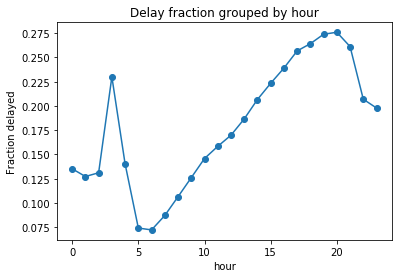

In [18]:
for df in (delayed_by_hour, delayed_by_month, delayed_by_year):
    f, ax = plt.subplots()
    df.sort_index(inplace=True)
    ax.plot(df.index, df.values, '-o')
    ax.set_title(f'Delay fraction grouped by {df.index.name}')
    ax.set_xlabel(df.index.name)
    ax.set_ylabel(f'Fraction {df.name}')

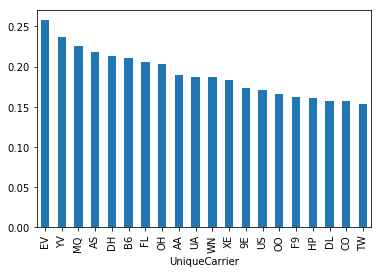

In [19]:
delayed_by_carrier.sort_values(ascending=False).plot(kind='bar')

* `EV`: Atlantic Southeast Airlines
* `YV`: Mesa Airlines
* `MQ`: Envoy Air
* `AS`: Alaska Airlines
* `DH`: Discovery Airways

# Other medium sized datasets


These are some medium sized data that are good examples of when dask is needed.

NYCTaxi
------

[Download link](http://www.andresmh.com/nyctaxitrips/)

Taxi trips taken in 2013 released by a FOIA request.  Around 20GB CSV uncompressed.

**Try the following:**

*  Use `dask.dataframe` with pandas-style queries
*  Store in HDF5 both with and without categoricals, measure the size of the file and query times
*  Set the index by one of the date-time columns and store in castra (also using categoricals).  Perform range queries and measure speed.  What size and complexity of query can you perform while still having an "interactive" experience?

Github Archive
----------------

[Download link](https://www.githubarchive.org/)

Every public github event for the last few years stored as gzip compressed line-delimited JSON data.  Watch out, the schema switches at the 2014-2015 transition.

**Try the following:**

*  Use `dask.bag` to inspect the data
*  Drill down using functions like `pluck` and `filter`
*  Find who the most popular committers were in 2015

Reddit Comments
-----------------

[Download link](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)

Every publicly available reddit comment, available as a large torrent

**Try the following:**

*  Use `dask.bag` to inspect the data
*  Combine `dask.bag` with `nltk` or `gensim` to perform textual analyis on the data
*  Reproduce the work of [Daniel Rodriguez](http://danielfrg.com/blog/2015/07/21/reproduceit-reddit-word-count-dask/) and see if you can improve upon his speeds when analyzing this data.

NYC 311
---------

[Download link](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)

All 311 service requests since 2010 in New York City

European Centre for Medium Range Weather Forecasts
----------------------------------------------------------

[Download script](https://gist.github.com/mrocklin/26d8323f9a8a6a75fce0)

Download historical global weather data from the ECMWF.

**Try the following:**

*  What is the variance in temperature over time?
*  What areas experienced the largest temperature swings in the last month relative to their previous history?
*  Plot the temperature of the earth as a function of latitude and then as longitude